# DDoS attacks detection and characterization

First, we need to import the necessary libraries.

In [2]:
# import needed python libraries

%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Data exploration and pre-processing
Now, we load the dataset from the .csv file provided.

In [3]:
# Load the dataset
df = pd.read_csv("ddos_dataset.csv", header=0, index_col=0, engine='python')

# Remove leading and trailing spaces from column names
df.columns = df.columns.str.strip()

df


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,label
0,172.16.0.5-192.168.50.1-634-60495-17,172.16.0.5,634,192.168.50.1,60495,17,2018-12-01 10:51:39.813448,28415,97,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
1,172.16.0.5-192.168.50.1-60495-634-17,192.168.50.1,634,172.16.0.5,60495,17,2018-12-01 10:51:39.820842,2,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,ddos_dns
2,172.16.0.5-192.168.50.1-634-46391-17,172.16.0.5,634,192.168.50.1,46391,17,2018-12-01 10:51:39.852499,48549,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
3,172.16.0.5-192.168.50.1-634-11894-17,172.16.0.5,634,192.168.50.1,11894,17,2018-12-01 10:51:39.890213,48337,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
4,172.16.0.5-192.168.50.1-634-27878-17,172.16.0.5,634,192.168.50.1,27878,17,2018-12-01 10:51:39.941151,32026,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65995,172.16.0.5-192.168.50.1-38625-63051-17,172.16.0.5,38625,192.168.50.1,63051,17,2018-12-01 13:04:46.628249,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
65996,172.16.0.5-192.168.50.1-58632-18963-17,172.16.0.5,58632,192.168.50.1,18963,17,2018-12-01 13:04:46.628963,212238,6,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
65997,172.16.0.5-192.168.50.1-46104-64704-17,172.16.0.5,46104,192.168.50.1,64704,17,2018-12-01 13:04:46.629014,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
65998,172.16.0.5-192.168.50.1-60686-10440-17,172.16.0.5,60686,192.168.50.1,10440,17,2018-12-01 13:04:46.629016,108952,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag


### 1.3.1 Correlation analysis
In order to analyze the correlation, we need to compute the correlation between each pair of features, which can be done using the pandas function ``.corr()`` (<a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html?highlight=corr#pandas.DataFrame.corr">documentation</a>). It calculate the Pearson correlation coefficient (<a href="https://en.wikipedia.org/wiki/Pearson_correlation_coefficient">Wiki</a>) between two numerical features, which is a value between -1 and 1. Normally, we take the absolute value, and the closer to 1 the higher the correlation.
$$ r = \frac{n(\sum xy) - (\sum x)(\sum y)}{\sqrt{[n\sum x^2 - (\sum x)^2][n\sum y^2 - (\sum y)^2]}} $$
<!-- $$ r = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum (x_i - \bar{x})^2} \sqrt{\sum (y_i - \bar{y})^2}} $$ -->
The result of correlation analysis can be displayed in a heatmap (<a href="https://seaborn.pydata.org/generated/seaborn.heatmap.html">documentation</a>), which is a symmetric matrix, indicating the correlation coefficient between each pair of features (even a feature with itself).

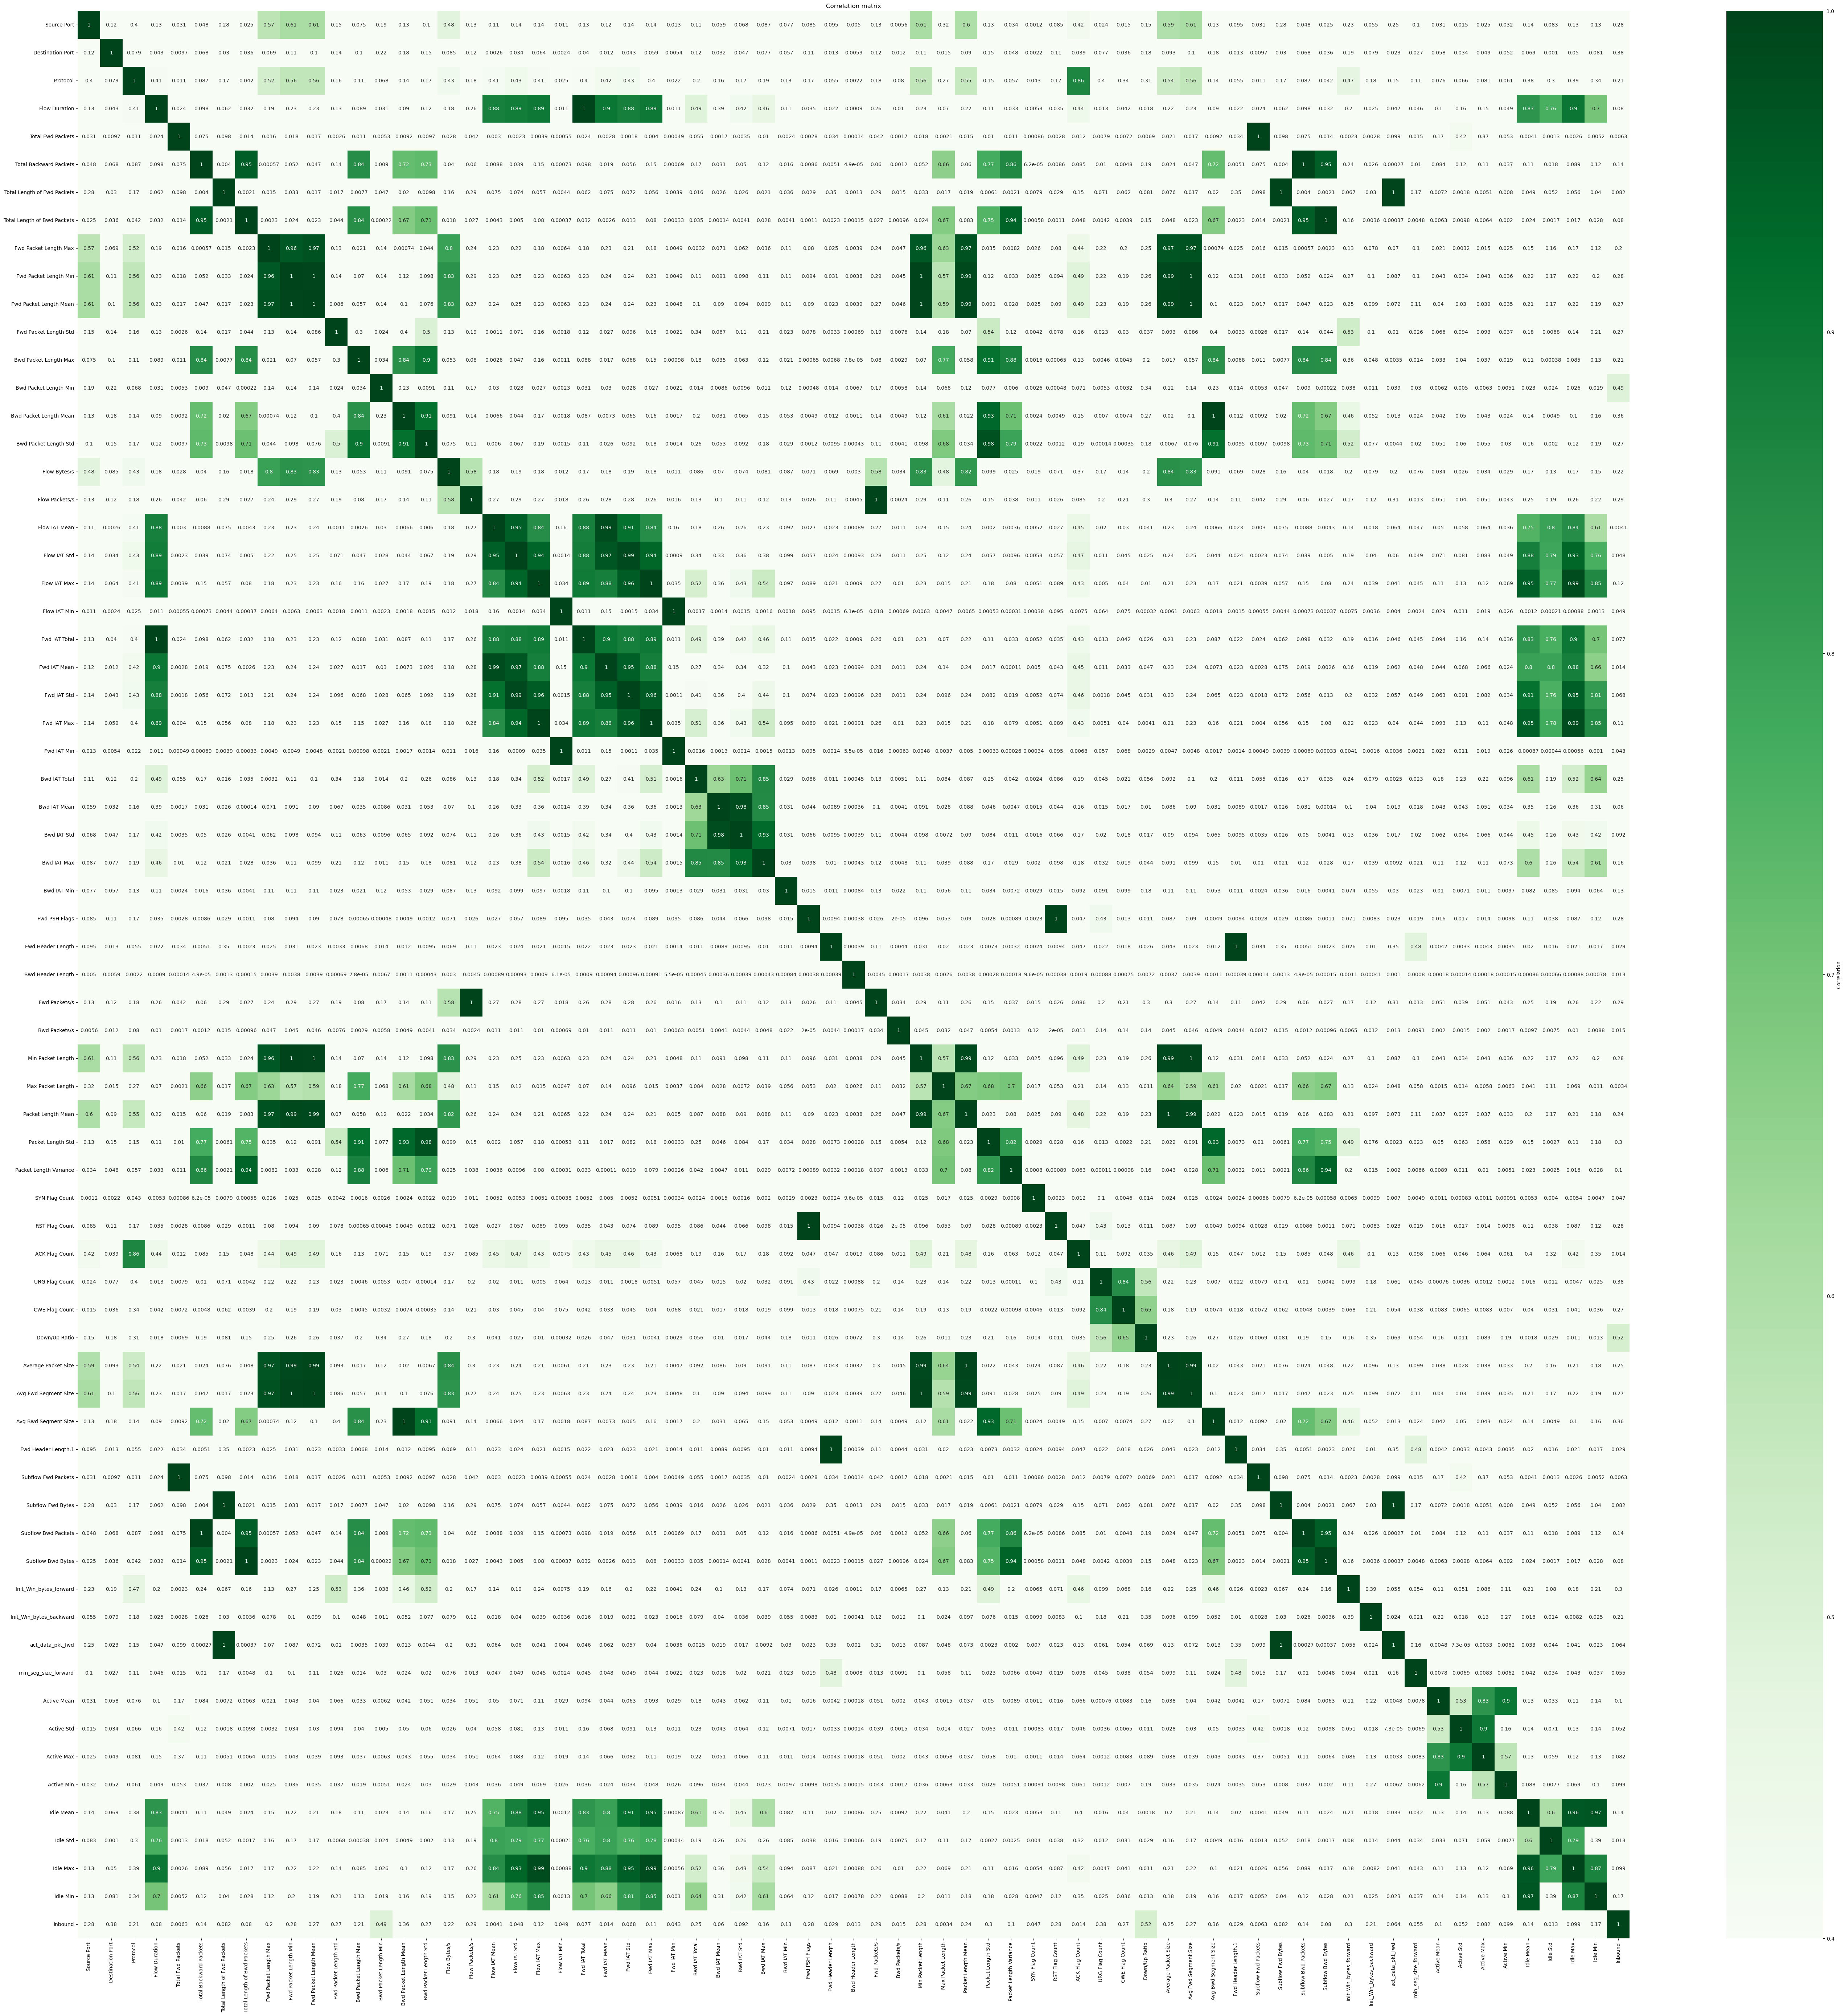

Original dataset: (64239, 87)
Cleaned dataset: (64239, 81)


In [4]:
# Select the numerical and categorical features
categorical_features = df.select_dtypes(exclude=['number']).columns.tolist()
numerical_features = [col for col in df.columns if col not in categorical_features]

# Verifica e conversione forzata a numerico (ignorando errori di conversione)
df_clean = df[numerical_features].apply(pd.to_numeric, errors='coerce')

# Calcolo della varianza per identificare le feature valide (con varianza maggiore di 0)
df_filtered = df_clean.loc[:, df_clean.var() > 0]       # poiché queste feature non contribuiscono alla correlazione e possono introdurre rumore

# Compute the correlation matrix
correlation_matrix = df_filtered.corr().abs()
#correlation_matrix = df.drop(columns=categorical_features).corr().abs()    # we take the absolute value to focus on the strength of the correlation

# Compute the heatmap (correlation matrix)
plt.figure(figsize=(len(correlation_matrix.columns), len(correlation_matrix.columns)))
sns.heatmap(correlation_matrix, cmap='Greens', annot=True, vmin=0.4, vmax=1, cbar_kws={'label':'Correlation'})      # we show the correlation when it is > 0.4
plt.title('Correlation matrix')
plt.show()

print("Original dataset:", df.shape)
print("Cleaned dataset:", df_clean.shape)

In [5]:
# Creiamo una matrice booleana per individuare la parte superiore della matrice
threshold = 0.9
upper_triangle = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)       # costruisco una maschera che identifica solo la parte superiore della matrice di correlazione per evitare duplicati (le correlazioni sono simmetriche)

# Selezioniamo le feature altamente correlate
highly_correlated_features = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.iloc[i, j] > threshold:
            colname = correlation_matrix.columns[i]
            if colname not in highly_correlated_features:
                highly_correlated_features.append(colname)

# Rimuoviamo le feature altamente correlate
df_reduced = df_filtered.drop(columns=highly_correlated_features)


print(f"Removed features {len(highly_correlated_features)} (with treshold = {threshold}) -> {highly_correlated_features}")
print(f"Remaining features: {df_reduced.shape[1]}")

Removed features 31 (with treshold = 0.9) -> ['Total Length of Bwd Packets', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Max', 'Fwd Packets/s', 'Min Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'RST Flag Count', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Header Length.1', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'act_data_pkt_fwd', 'Idle Mean', 'Idle Max', 'Idle Min']
Remaining features: 38


### Principal Component Analysis (PCA)
Use a number components where you meet the elbow point. i.e., if increasing the number of components does not increase much the cumulative explained variance.

<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
/var/folders/0j/7hqbq94s1cx1wwg493v81ggr0000gn/T/ipykernel_2369/1989468668.py:17: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f'2 PCs explain {round(perc_cumul_exp_var[1], 2)}% of $\sigma^2$')        # round(perc_cumul_exp_var[1], 2) calculates the percentage explained by the first 2 PCs


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


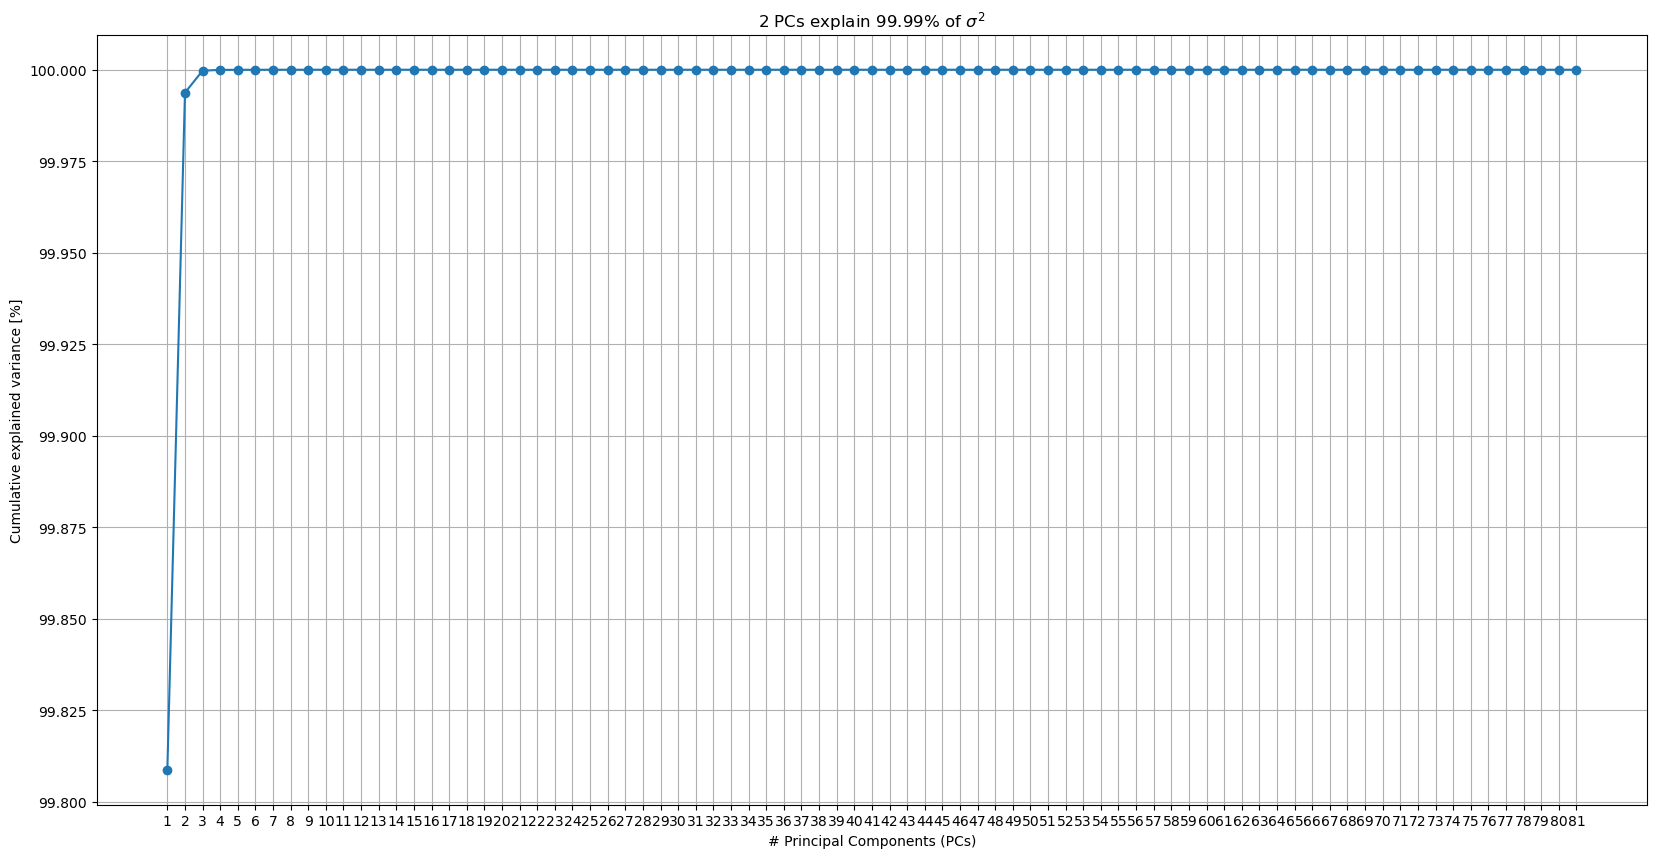

In [6]:
pca = PCA(random_state=42)      # PCA must be initialized with a random state to initialize the space
pca.fit(df[numerical_features].dropna())    # compute the new dimensions with number of features from 1 to the number of original features
                                            # .dropna() is for deleting NaN values


explained_variance = pca.explained_variance_ratio_      # describe how much of the dataset variability is indicated by a given amount of features
cumul_exp_var = np.cumsum(explained_variance)       # evaluate the total dataset variability while increasing the variables
perc_cumul_exp_var = cumul_exp_var * 100        # percentage value to better understand the best number of components

# make the plot of cumulative explained variance with respect to number of components
plt.figure(figsize=(20,10))
plt.plot(perc_cumul_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks([i for i in range(len(numerical_features))], [i for i in range(1,len(numerical_features)+1)])
plt.grid()
plt.title(f'2 PCs explain {round(perc_cumul_exp_var[1], 2)}% of $\sigma^2$')        # round(perc_cumul_exp_var[1], 2) calculates the percentage explained by the first 2 PCs
plt.show()



<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
/var/folders/0j/7hqbq94s1cx1wwg493v81ggr0000gn/T/ipykernel_2369/2425814939.py:19: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f'2 PCs explain {round(perc_cumul_exp_var[1], 2)}% of $\sigma^2$')        # round(perc_cumul_exp_var[1], 2) calculates the percentage explained by the first 2 PCs


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


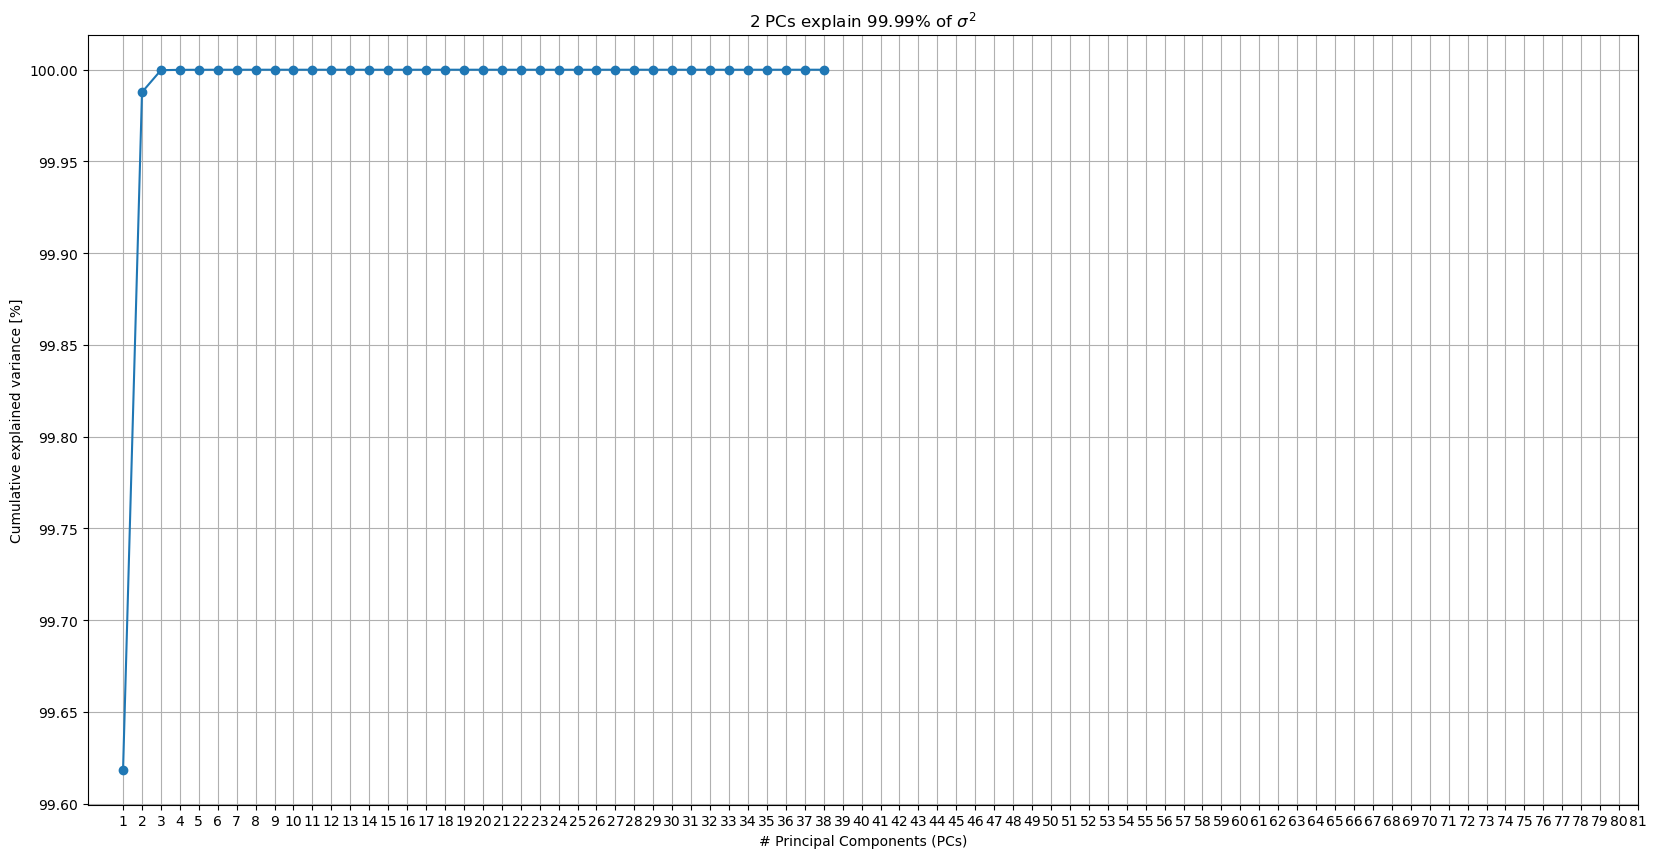

In [7]:
# OPPURE: applico PCA su df_reduced

pca = PCA(random_state=52)      # PCA must be initialized with a random state to initialize the space
pca.fit(df_reduced.dropna())    # compute the new dimensions with number of features from 1 to the number of original features
                                            # .dropna() is for deleting NaN values


explained_variance = pca.explained_variance_ratio_      # describe how much of the dataset variability is indicated by a given amount of features
cumul_exp_var = np.cumsum(explained_variance)       # evaluate the total dataset variability while increasing the variables
perc_cumul_exp_var = cumul_exp_var * 100        # percentage value to better understand the best number of components

# make the plot of cumulative explained variance with respect to number of components
plt.figure(figsize=(20,10))
plt.plot(perc_cumul_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks([i for i in range(len(numerical_features))], [i for i in range(1,len(numerical_features)+1)])
plt.grid()
plt.title(f'2 PCs explain {round(perc_cumul_exp_var[1], 2)}% of $\sigma^2$')        # round(perc_cumul_exp_var[1], 2) calculates the percentage explained by the first 2 PCs
plt.show()